<a href="https://colab.research.google.com/github/NiklasElsaesser/DataVisualization/blob/main/C_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment1 "Creating Visualization"

## Prerequisits
Installing the Python Library Pandas and Numpy

In [ ]:
%pip install pandas
%pip install numpy
%pip install wandb

In [ ]:
%pip install Matplotlib
%pip install Seaborn
%pip install Plotly
%pip install kaleido
%pip install imageio

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import wandb

In [31]:
#wandb.init(project="Creating Visualization")

# Used Dataset

In [32]:
import pandas as pd

# Read the CSV file into a DataFrame
file_path = "/content/drive/MyDrive/DataVisual/ds_visualisation.csv"
df = pd.read_csv(file_path)

# Perform the operation to extract 'Name' from 'Image Path'
df['Name'] = df['Image Path'].str.split('_').str[0]

# Extract 'actual_emotion' from 'Image Path'
df['actual_emotion'] = df['Image Path'].str.extract(r'_(\w+)\.')[0].fillna('')

# Save the modified DataFrame as a new CSV file
#df.to_csv("/content/drive/MyDrive/DataVisual/extended_ds_vis.csv", index=False)


# Print the DataFrame
print(df)

                    Image Path Predicted Gender Predicted Emotion  \
0              jan_neutral.jpg              Men           Neutral   
1                jan_happy.jpg              Men           Neutral   
2             anna_neutral.jpg              Men           Neutral   
3            bernice_happy.jpg            Women             Happy   
4          bernice_neutral.jpg            Women             Happy   
5             anna_happy_2.jpg            Women             Happy   
6         niklas_neutral_1.jpg              Men           Neutral   
7           niklas_happy_1.jpg              Men           Neutral   
8           anna_neutral_2.jpg            Women             Happy   
9   niklas_neutral_woBeard.jpg              Men           Neutral   
10    niklas_happy_woBeard.jpg              Men           Neutral   

   Correct Prediction     Name   actual_emotion  
0             Correct      jan          neutral  
1           Incorrect      jan            happy  
2           Incorrect

## Adding df to WandB

In [33]:
# Create a wandb Table
table = wandb.Table(dataframe=df, allow_mixed_types=True)  # Convert DataFrame to wandb Table

# Log the Table
wandb.log({"4facebias_predictions": table})

# Visualizing

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
from PIL import Image
import io


PIE Chart

In [35]:
# Count the number of correct and incorrect predictions by gender
gender_counts = df.groupby(['Predicted Gender', 'Correct Prediction']).size().reset_index(name='Count')

# Define colors
colors = ['#1f77b4', '#aec7e8', '#9467bd', '#c5b0d5']  # Shades of blue for men, purple for women

# Create hover text
hover_text = gender_counts['Predicted Gender'] + ' (' + gender_counts['Correct Prediction'] + ')'

# Create a pie chart
fig = go.Figure(data=[go.Pie(labels=hover_text,
                             values=gender_counts['Count'],
                             hole=0.3,
                             marker_colors=colors,
                             textinfo='none',  # Disable text info in the chart
                             hoverinfo='label+percent+text',  # Show hover info including gender
                             title='Incorrect vs. Correct Predictions by Gender',
                             )])

# Update layout
fig.update_layout(title_text='Incorrect vs. Correct Predictions by Gender', title_x=0.5)

# Log the interactive plot to Wandb
#wandb.init(project="your-project-name", entity="your-entity-name")  # Initialize Wandb
wandb.log({"Incorrect_vs_Correct_Predictions_Pie": fig})

# Finish logging
#wandb.finish()


Gender vs. Emotion

<Figure size 1000x600 with 0 Axes>

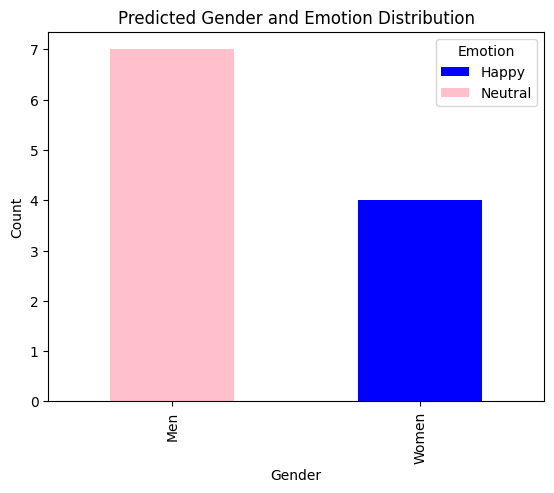

In [37]:
# Counting the occurrences of each combination of Predicted Gender and Predicted Emotion
gender_emotion_counts = df.groupby(['Predicted Gender', 'Predicted Emotion']).size().unstack()

# Creating a stacked bar chart
plt.figure(figsize=(10, 6))
gender_emotion_counts.plot(kind='bar', stacked=True, color=['blue', 'pink', 'green', 'gray'])
plt.title('Predicted Gender and Emotion Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Emotion', loc='upper right')

# Save plot to buffer
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Convert buffer to numpy array
buf_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)

# Reshape the array to match the expected image shape
img = plt.imread(BytesIO(buf_array))
buf_array = np.array(img)

# Create a plotly figure
fig = go.Figure(data=[go.Bar(x=gender_emotion_counts.index, y=gender_emotion_counts[emotion], name=emotion)
                      for emotion in gender_emotion_counts.columns])

# Adjust layout
fig.update_layout(
    title='Predicted Gender and Emotion Distribution',
    xaxis_title='Gender',
    yaxis_title='Count',
    width=1000,
    height=600
)

# Log the figure to Wandb
wandb.log({"Gender_Emotion_Distribution": fig})

# Log the image to Wandb
wandb.log({"Gender_Emotion_Plot": wandb.Image(buf_array)})



Gender Accuracy

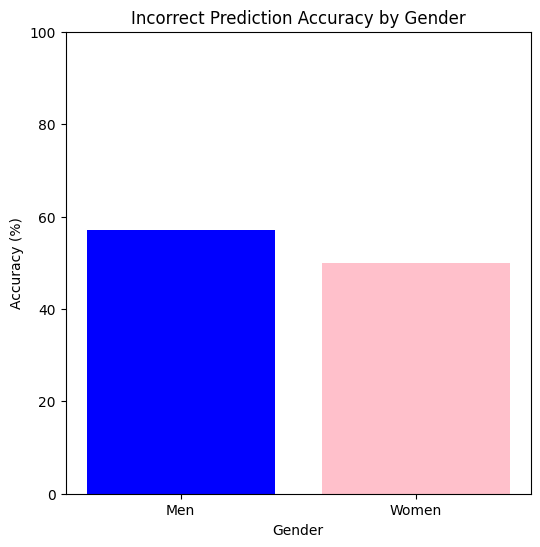

In [38]:
# Calculate accuracy for incorrect predictions for Men and Women
men_incorrect_accuracy = df.loc[(df['Predicted Gender'] == 'Men') & (df['Correct Prediction'] == 'Incorrect')].shape[0] / df.loc[df['Predicted Gender'] == 'Men'].shape[0] * 100
women_incorrect_accuracy = df.loc[(df['Predicted Gender'] == 'Women') & (df['Correct Prediction'] == 'Incorrect')].shape[0] / df.loc[df['Predicted Gender'] == 'Women'].shape[0] * 100

# Bar chart for Incorrect Prediction Accuracy by Gender
plt.figure(figsize=(6, 6))
plt.bar(['Men', 'Women'], [men_incorrect_accuracy, women_incorrect_accuracy], color=['blue', 'pink'])
plt.title('Incorrect Prediction Accuracy by Gender')
plt.xlabel('Gender')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Save plot to buffer
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Convert buffer to numpy array
buf_array = np.array(plt.imread(buf))

# Log the image to Wandb
wandb.log({"Prediction_Gender_Accuracy": wandb.Image(buf_array)})


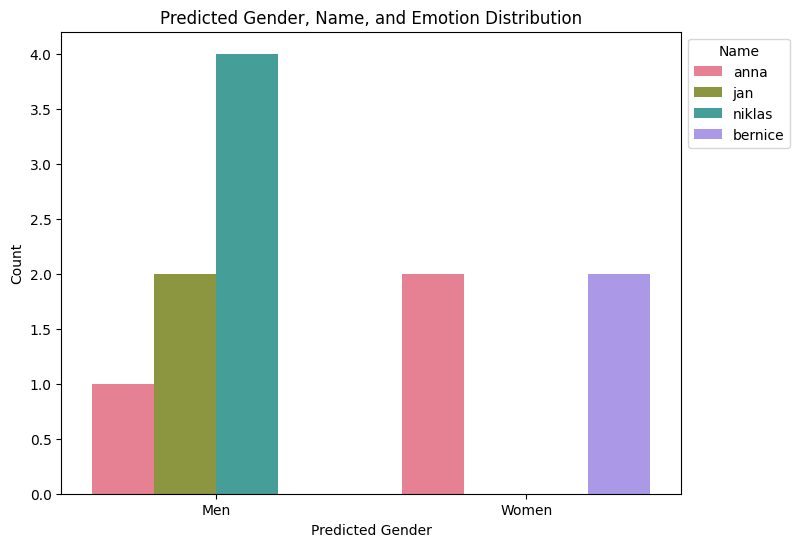

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wandb
from io import BytesIO

# Assume df is your DataFrame

# Group the DataFrame by 'Predicted Gender', 'Name', and 'Predicted Emotion', and count the occurrences
grouped_df = df.groupby(['Predicted Gender', 'Name', 'Predicted Emotion']).size().reset_index(name='Count')

# Plotting the grouped bar chart with a smaller size
plt.figure(figsize=(8, 6))
sns.barplot(x='Predicted Gender', y='Count', hue='Name', data=grouped_df, dodge=True, palette='husl')
plt.title('Predicted Gender, Name, and Emotion Distribution')
plt.xlabel('Predicted Gender')
plt.ylabel('Count')
plt.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')

# Save plot to buffer
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Convert buffer to numpy array
buf_array = np.array(plt.imread(buf))

# Log the image to Wandb
wandb.log({"Prediction-by_Gen-Name-Emotion": wandb.Image(buf_array)})

# Show the plot (if needed)
plt.show()


In [40]:
#--------------------------
#------------------------
import pandas as pd
import wandb
import plotly.express as px

# Assume df is your DataFrame

# Group the DataFrame by 'Predicted Gender', 'Name', and 'Predicted Emotion', and count the occurrences
grouped_df = df.groupby(['Predicted Gender', 'Name', 'Predicted Emotion']).size().reset_index(name='Count')

# Plotting the grouped bar chart
fig = px.bar(grouped_df,
             x='Predicted Gender',
             y='Count',
             color='Name',
             barmode='group',
             title='Predicted Gender, Name, and Emotion Distribution',
             labels={'Predicted Gender': 'Predicted Gender', 'Count': 'Count'},
             category_orders={'Name': sorted(grouped_df['Name'].unique())})

# Log the figure to W&B
wandb.log({"Prediction-by_Gen-Name-Emotion-I": fig})

# Show the plot (if needed)
fig.show()


Matrix

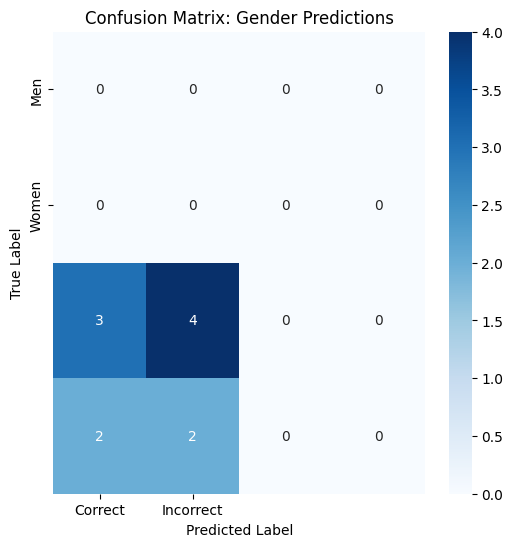

In [41]:
# Generate a confusion matrix for gender predictions
conf_matrix = confusion_matrix(df['Predicted Gender'], df['Correct Prediction'])

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Correct', 'Incorrect'], yticklabels=['Men', 'Women'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Gender Predictions')

# Save plot to buffer
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Convert buffer to numpy array
buf_array = np.array(plt.imread(buf))

# Log the image to Wandb
wandb.log({"Matrix": wandb.Image(buf_array)})

plt.show()

## Additional Task
&#9745; Experimentieren Sie mit verschiedenen Python-Visualisierungsbibliotheken und deren Stärken.\
&#9745; Erstellen Sie interaktive Visualisierungen mit Bibliotheken wie Plotly.\
&#9745; Integrieren Sie Ihr Python-Skript in ein Jupyter Notebook für eine strukturierte Analyse.

In [42]:
wandb.finish()